In [3]:

import pandas as pd
from config import *

data = pd.read_csv(formated_train, sep=';')

# convertir fecha a datetime y luego a int
data['fechaUltimaActualizacion'] = pd.to_datetime(data['fechaUltimaActualizacion'])
data['fechaUltimaActualizacion'] = data['fechaUltimaActualizacion'].astype('int64')

In [4]:
import joblib
from sklearn.preprocessing import StandardScaler

features = ['terrenoEdificado', 'coordX', 'coordY', 'barrio', 'fechaUltimaActualizacion']
data_for_clustering = data[features]

scaler_kmeans = StandardScaler()
scaled_data = scaler_kmeans.fit_transform(data_for_clustering)

kmeans = joblib.load(kmeans_model)
data['clusterKM'] = kmeans.predict(scaled_data)

In [5]:
import joblib
from sklearn.model_selection import train_test_split

ensamble = joblib.load(ensamble_precio_model)

features = ['terrenoEdificado', 'comisariaCercana', 'transporteCercano', 
            'saludCercana', 'coordX', 'coordY', 'clusterKM', 'barrio', 'fechaUltimaActualizacion']
data_for_train = data[features]
target_column = 'precioUSD'
target = data[target_column]

scaler_ensamble = StandardScaler()
scaled_data = scaler_ensamble.fit_transform(data_for_train)

X_train, X_test, y_train, y_test = train_test_split(data_for_train, target, train_size=0.99, random_state=33)

ensamble

VotingRegressor(estimators=[('knn7',
                             KNeighborsRegressor(algorithm='ball_tree',
                                                 n_neighbors=7,
                                                 weights='distance')),
                            ('knn8',
                             KNeighborsRegressor(algorithm='ball_tree',
                                                 n_neighbors=8,
                                                 weights='distance')),
                            ('knn6',
                             KNeighborsRegressor(algorithm='ball_tree',
                                                 n_neighbors=6,
                                                 weights='distance')),
                            ('knn11',
                             KNeighborsRegressor(algorithm='ball_tree',
                                                 n_neighbors=11,
                                                 w...
                            ('knn10',
                             KNeighborsRegressor(algorithm='ball_tree',
                                                 n_neighbors=10,
                                                 weights='distance')),
                            ('knn5',
                             KNeighborsRegressor(algorithm='ball_tree',
                                                 weights='distance')),
                            ('RF',
                             RandomForestRegressor(n_estimators=800,
                                                   random_state=42)),
                            ('XGBoost',
                             GradientBoostingRegressor(learning_rate=0.05,
                                                       max_depth=8,
                                                       n_estimators=200,
                                                       random_state=42))],
                weights=[4, 3, 3, 2, 2, 1, 1, 4, 4])

In [6]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X_test_scaled = scaler_ensamble.transform(X_test)
all_data_predictions = ensamble.predict(X_test_scaled)

ensemble_r2 = r2_score(y_test, all_data_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, all_data_predictions))

print(f'Ensamble R2: {ensemble_r2}')
print(f'Ensamble RMSE: {ensemble_rmse}')

Ensamble R2: 0.8562784673097436
Ensamble RMSE: 31030.90300354034


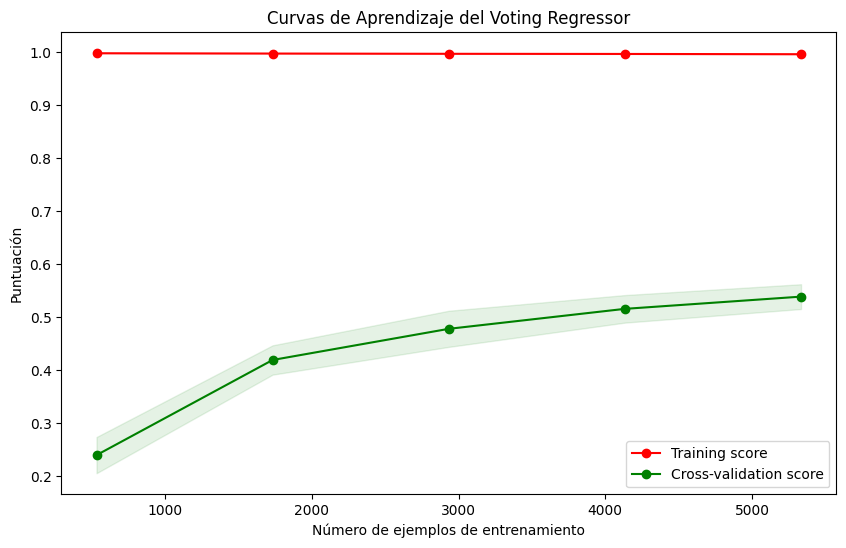

In [7]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# Supongamos que ya tienes definidos X_train, y_train y el modelo voting_regressor

# Obtener curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(ensamble, X_train, y_train, cv=5)

# Calcular medias y desviaciones estándar de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Visualizar curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Curvas de Aprendizaje del Voting Regressor")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("Puntuación")
plt.legend(loc="best")
plt.show()